# Demo Global Z2M P4M Self-Attention

In this demo, we will analyze the equivariance properties of p4m group-equivariant self-attention models (i.e., to rotations by 90 degrees and reflections).

First, we will demonstrate the translation equivariance of the model and, subsequently, we will perform an analysis into the rotation and reflection equivariance properties of the model.

## Importing Libraries
Add the library to the system path via the relative folder structure:

In [1]:
import os,sys
g_selfatt_source =  os.path.join(os.getcwd(),'..')
if g_selfatt_source not in sys.path:
    sys.path.append(g_selfatt_source)

Import the necessary libraries:

In [2]:
# torch
import torch
import torch.nn as nn
# project
import g_selfatt
# other
from matplotlib import pyplot as plt
import importlib

## P4M Self-Attention Layers

**Important** Note that P4M-net without rotations is equivalent to a reflection equivariant network. Examples are given bellow.

In what follows we take:

* a random noise image f as input
* apply a sequence of p4m self-attention layers to it f -> N(f)
* translate the input (T(f)) via the action of the translation group on f and send it through the same sequence of layers and (T(f) -> N(T(f)))
* then we test the equivariance property T'(N(f))=N(T(f)) In the above T denotes the translation operator of 2D images, and T' denotes the translation operator on feature maps.

Afterwards, we repeat the process for rotations:

* apply a sequence of p4m self-attention layers to it f -> N(f)
* rotate the input (R(f)) via the action of the rotation group on f and send it through the same sequence of layers and (R(f) -> N(R(f)))
* then we test the equivariance property R'(N(f))=N(R(f)) In the above R denotes the rotation operator of 2D images, and R' denotes the rotation operator (shift-twist) of E(2) images, which is a planar rotation and a periodic shift along the extra rotation axis.

To finalize, we repeat the process for reflections:

* apply a sequence of p4m self-attention layers to it f -> N(f)
* reflect the input (M(f)) via the action of the reflection group on f and send it through the same sequence of layers and (M(f) -> N(M(f)))
* then we test the equivariance property M'(N(f))=N(M(f)). In the above M denotes the reflection operator of 2D images, and M' denotes the reflection operator (shift-twist) of E(2) images, which is a planar reflection and a periodic shift along the extra reflection axis.


Now, let us create a net with two self-attention layers, with a total of 3 ** 2 heads:

### The input feature map

In [3]:
Nxy = 9 # This spatial dimension
N_in = 10 # This many feature channels
B = 4 # Batch size
# For now we work with a placeholder
inputs = torch.randn([B,N_in,Nxy,Nxy], dtype=torch.float32)
inputs[:,:, :2, :] = 0.0 
inputs[:,:, :, :2] = 0.0 
inputs[:,:, -2:,:] = 0.0 
inputs[:,:, :, -2:] = 0.0 

### Attention Layers

In [4]:
# Layer parameters
num_heads = 3 ** 2

# Construct the group we want to test equivariance on.
num_elements = 8
group = g_selfatt.groups.E2(num_elements)

# Construct the layers.
sa_1 = g_selfatt.nn.LiftSelfAttention(
        group=group,
        in_channels=N_in,
        mid_channels=N_in,
        out_channels=N_in * 2,
        num_heads=num_heads,
        max_pos_embedding=Nxy,
        attention_dropout_rate=0.)

sa_2 = g_selfatt.nn.GroupSelfAttention(
    group=group,
        in_channels=N_in * 2, 
        mid_channels=N_in, 
        out_channels=N_in * 4,
        num_heads=num_heads,
        max_pos_embedding=Nxy,
        attention_dropout_rate=0.)

### Test the network - Translation Equivariance

We create random noise input and translated noise:

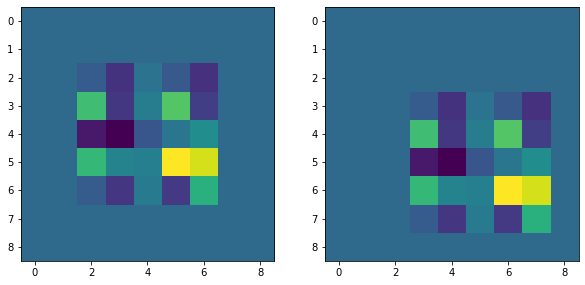

In [5]:
input_tensor = inputs
input_tensor_trans = torch.roll(inputs, (1,1), dims=(-2,-1))

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_trans.numpy()[0,0,:,:,])
plt.show()

Pass the original random signal to the network and then its translated version

In [6]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_trans = sa_1(input_tensor_trans)
out_2_trans = sa_2(out_1_trans)

Let's compare the results. Recall that now all feature maps are a funtion of the group. Thus it is composed of group.num_elements 'channels'.

FIRST LAYER:

The original input.


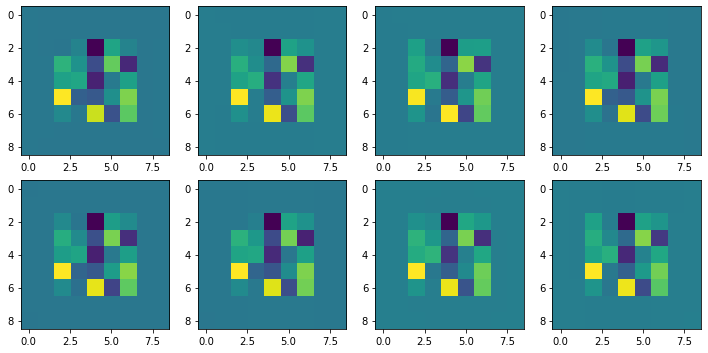

The translated input.


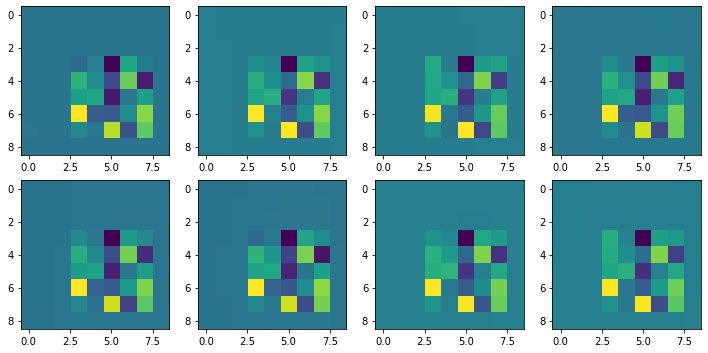


 SECOND LAYER:

The original input.


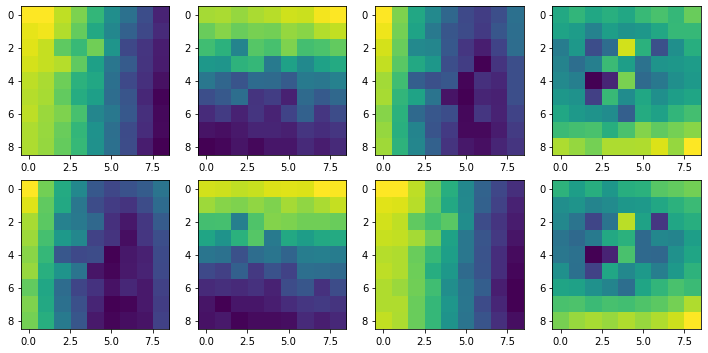

The translated input.


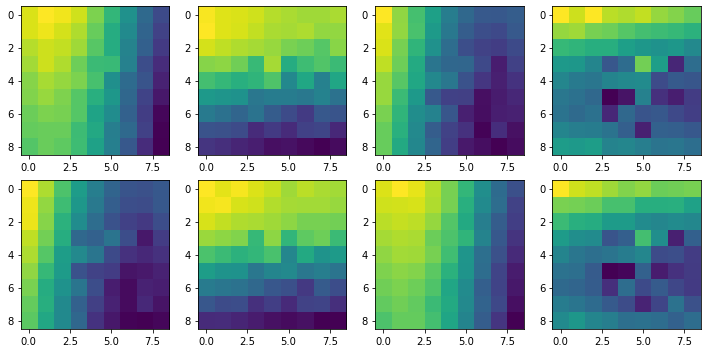

In [7]:
print('FIRST LAYER:\n')

print( 'The original input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:])
plt.tight_layout()
plt.show()

print( 'The translated input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1_trans.detach().numpy()[0,0,i,:,:])
plt.tight_layout()
plt.show()

print('\n SECOND LAYER:\n')

print( 'The original input.')
plt.subplots(2, group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2, group.num_elements // 2,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:])
plt.tight_layout()
plt.show()

print( 'The translated input.')
plt.subplots(2, group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2, group.num_elements // 2, i+1)
    plt.imshow(out_2_trans.detach().numpy()[0,0,i,:,:])
plt.tight_layout()
plt.show()

### Test the network - Rotation Equivariance

Now, let's analyze what occurs if the input image is rotated. Lets first see the input

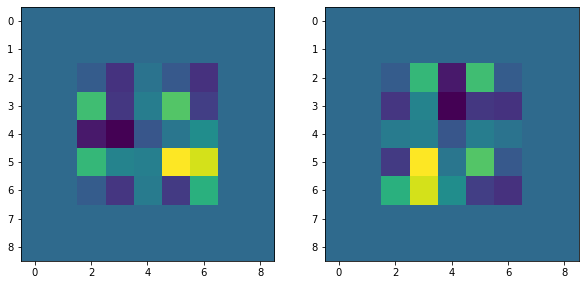

In [8]:
input_tensor = inputs
input_tensor_90 = inputs.rot90(k=-1, dims=[-2,-1])

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_90.numpy()[0,0,:,:,]);
plt.show()

Pass the original random signal to the network and then its rotated version

In [9]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_90 = sa_1(input_tensor_90)
out_2_90 = sa_2(out_1_90)

Let's compare the results

FIRST LAYER:

The original input.


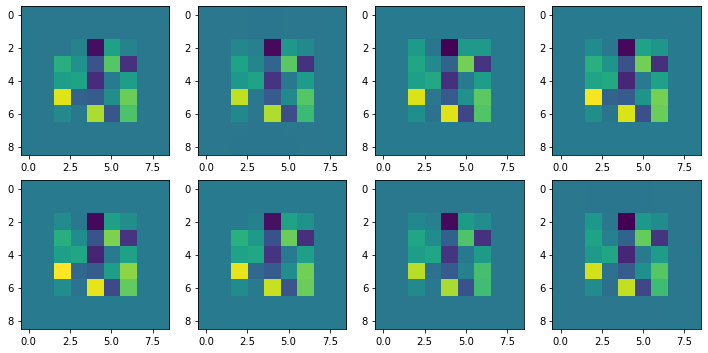

The rotated input.


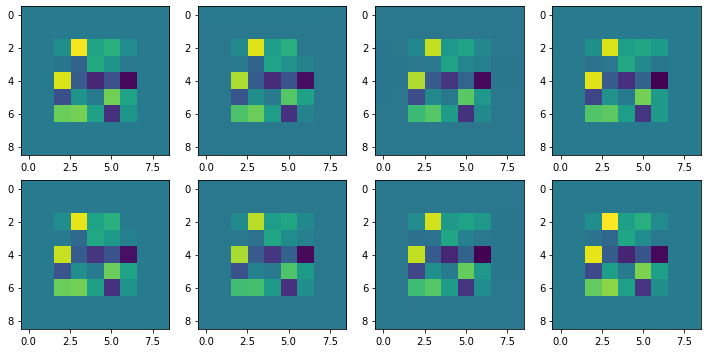


 SECOND LAYER:

The original input.


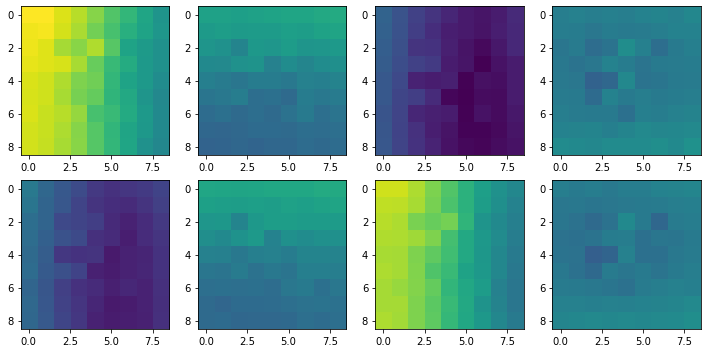

The rotated input.


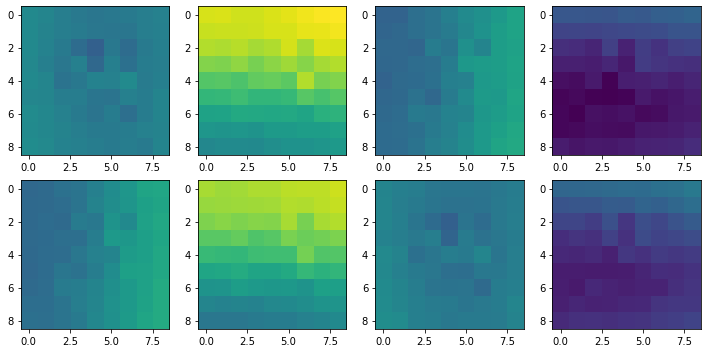

In [10]:
print('FIRST LAYER:\n')
vmax = torch.max(out_1[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_1_90[0,0,:,:,:]).item() < vmax else torch.max(out_1_90[0,0,:,:,:]).item()
vmin = torch.min(out_1[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_1_90[0,0,:,:,:]).item() < vmin else torch.min(out_1_90[0,0,:,:,:]).item()

print( 'The original input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print( 'The rotated input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1_90.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print('\n SECOND LAYER:\n')
vmax = torch.max(out_2[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_2_90[0,0,:,:,:]).item() < vmax else torch.max(out_2_90[0,0,:,:,:]).item()
vmin = torch.min(out_2[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_2_90[0,0,:,:,:]).item() < vmin else torch.min(out_2_90[0,0,:,:,:]).item()

print( 'The original input.')

plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print( 'The rotated input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_2_90.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

As we can see, the responses are equivalent for rotated versions of the same image. Up to a permutation of the axes (1 to the right in the upper 4 response channels and 1 to the left in the lower 4 response channels), and a rotation of each feature map (by a corresponding rotation to that of the input).

### Test the network - Reflection Equivariance

Now, let's analyze what occurs if the input image is reflected. Lets first see the input

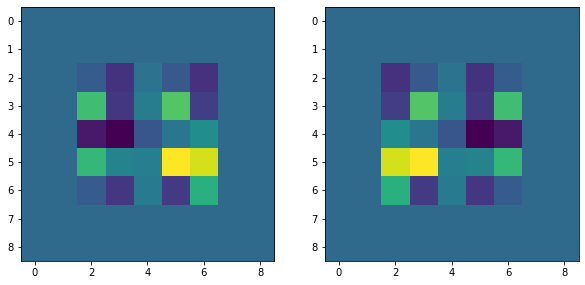

In [11]:
input_tensor = inputs
input_tensor_f = torch.flip(inputs, [-1])

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_f.numpy()[0,0,:,:,]);
plt.show()

Pass the original random signal to the network and then its reflected version

In [12]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_f = sa_1(input_tensor_f)
out_2_f = sa_2(out_1_f)

Let's compare the results

FIRST LAYER:

The original input.


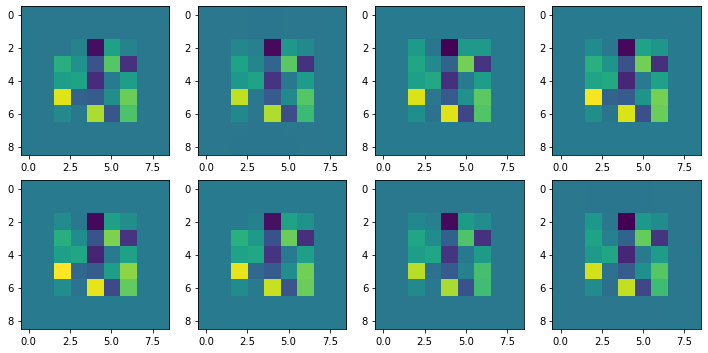

The reflected input.


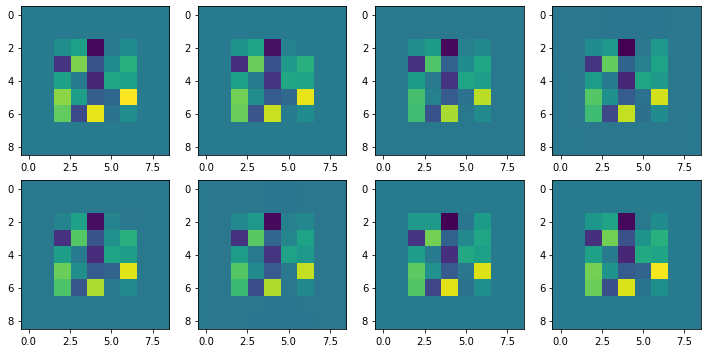


 SECOND LAYER:

The original input.


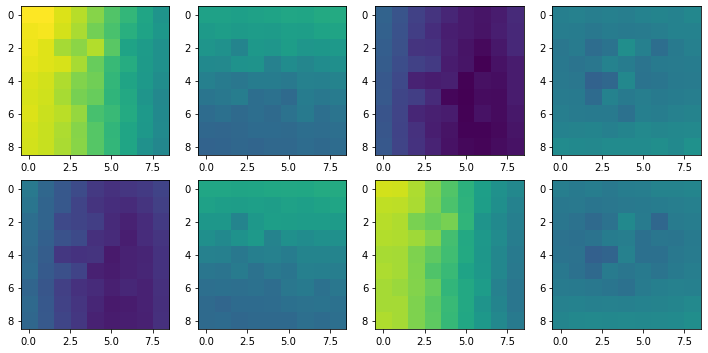

The reflected input.


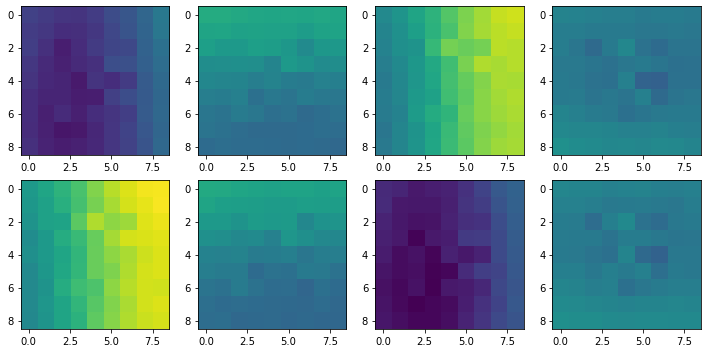

In [13]:
print('FIRST LAYER:\n')
vmax = torch.max(out_1[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_1_f[0,0,:,:,:]).item() < vmax else torch.max(out_1_f[0,0,:,:,:]).item()
vmin = torch.min(out_1[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_1_f[0,0,:,:,:]).item() < vmin else torch.min(out_1_f[0,0,:,:,:]).item()

print( 'The original input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print( 'The reflected input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1_f.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print('\n SECOND LAYER:\n')
vmax = torch.max(out_2[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_2_f[0,0,:,:,:]).item() < vmax else torch.max(out_2_f[0,0,:,:,:]).item()
vmin = torch.min(out_2[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_2_f[0,0,:,:,:]).item() < vmin else torch.min(out_2_f[0,0,:,:,:]).item()

print( 'The original input.')

plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print( 'The reflected input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_2_f.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

As we can see, the responses are equivalent for reflected versions of the same image, up to a permutation of the axes (the upper channels are permuted with the lower channels), and a reflection corresponding to that of the input.

### Final Test! - Rotation and Reflection Equivariance Simultaneously

Now, let's analyze what occurs if the input image is reflected and rotated at the same time. Lets first see the input

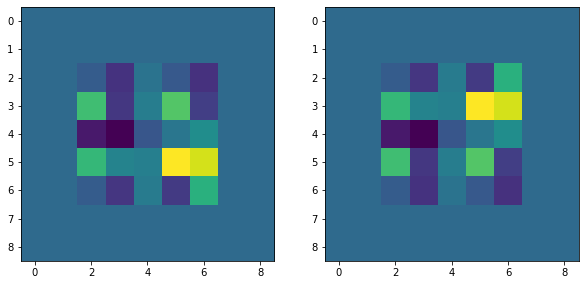

In [14]:
# A mirroring on the x axis is equivalent to a rotation by 180 degrees and a consequent mirroring over y.

input_tensor = inputs
input_tensor_rf = torch.flip(input_tensor, [-2])

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_rf.numpy()[0,0,:,:,]);
plt.show()

Pass the original random signal to the network and then its mirrored+reflected version

In [15]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_rf = sa_1(input_tensor_rf)
out_2_rf = sa_2(out_1_rf)

Let's compare the results

FIRST LAYER:

The original input.


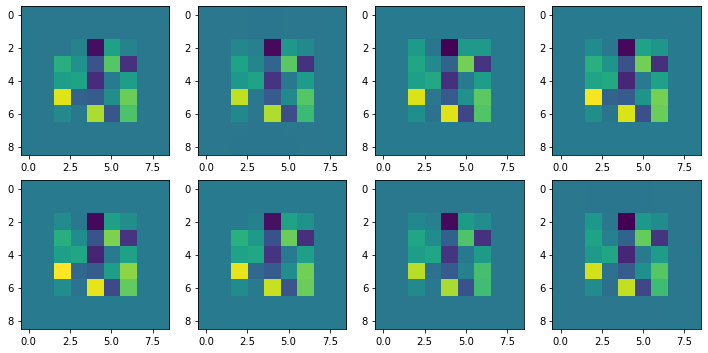

The modified input.


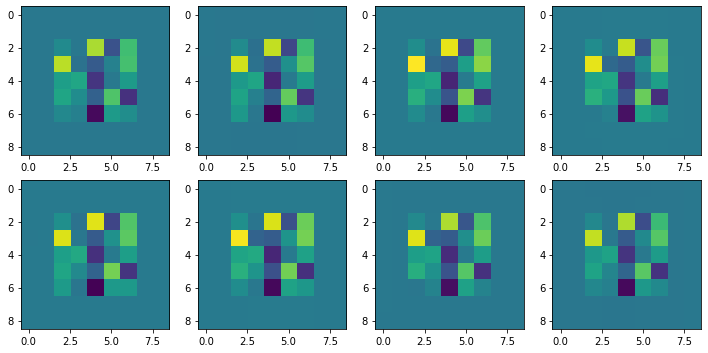


 SECOND LAYER:

The original input.


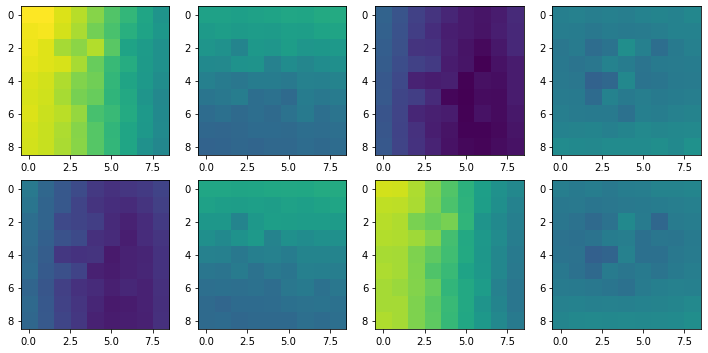

The modified input.


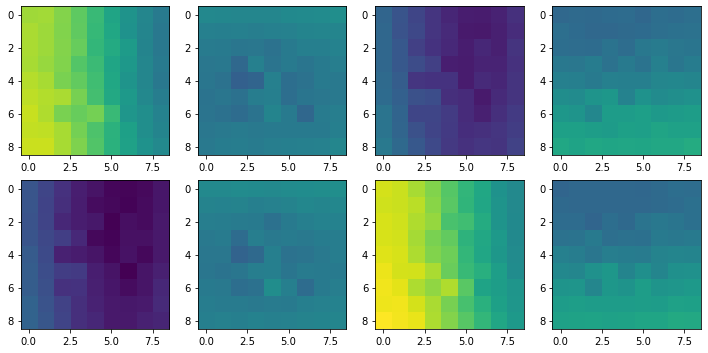

In [16]:
print('FIRST LAYER:\n')
vmax = torch.max(out_1[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_1_rf[0,0,:,:,:]).item() < vmax else torch.max(out_1_rf[0,0,:,:,:]).item()
vmin = torch.min(out_1[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_1_rf[0,0,:,:,:]).item() < vmin else torch.min(out_1_rf[0,0,:,:,:]).item()

print( 'The original input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print( 'The modified input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_1_rf.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print('\n SECOND LAYER:\n')
vmax = torch.max(out_2[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_2_f[0,0,:,:,:]).item() < vmax else torch.max(out_2_f[0,0,:,:,:]).item()
vmin = torch.min(out_2[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_2_f[0,0,:,:,:]).item() < vmin else torch.min(out_2_f[0,0,:,:,:]).item()

print( 'The original input.')

plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

print( 'The modified input.')
plt.subplots(2,group.num_elements // 2, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(2,group.num_elements // 2,i+1)
    plt.imshow(out_2_rf.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
plt.tight_layout()
plt.show()

Voila! :) As we can see, the responses indeed move correspondingly to a 180 degree rotation, followed by a reflection on the y axis. 

To see this, perform the following exercise:

* Mentally take a 180 rotation of any response followed by a reflection on the y axis. You will found that mental response by shifting 2 times along the row and then changing column.

Hence, the responses undergo a rotation by 180 degrees plus a permutation of 2 channels along their corresponding row, after which, the responses are reflected and the rows are permuted with one another.

### Reflection-Equivariant Layers

Now, we will analyze the effect of constructing layers equivariant only to mirroring over the y-axis.

In [17]:
Nxy = 9 # This spatial dimension
N_in = 10 # This many feature channels
B = 4 # Batch size
# For now we work with a placeholder
inputs = torch.randn([B,N_in,Nxy,Nxy], dtype=torch.float32)
inputs[:,:, :2, :] = 0.0 
inputs[:,:, :, :2] = 0.0 
inputs[:,:, -2:,:] = 0.0 
inputs[:,:, :, -2:] = 0.0 

In [18]:
# Layer parameters
num_heads = 3 ** 2

# Construct the group we want to test equivariance on.
num_elements = 2
group = g_selfatt.groups.E2(num_elements)

# Construct the layers.
sa_1 = g_selfatt.nn.LiftSelfAttention(
        group=group,
        in_channels=N_in,
        mid_channels=N_in,
        out_channels=N_in * 2,
        num_heads=num_heads,
        max_pos_embedding=Nxy,
        attention_dropout_rate=0.)

sa_2 = g_selfatt.nn.GroupSelfAttention(
    group=group,
        in_channels=N_in * 2, 
        mid_channels=N_in, 
        out_channels=N_in * 4,
        num_heads=num_heads,
        max_pos_embedding=Nxy,
        attention_dropout_rate=0.)

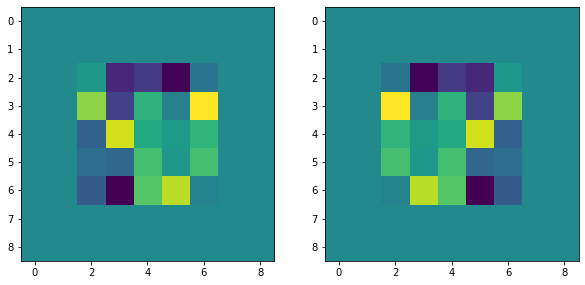

In [19]:
input_tensor = inputs
input_tensor_f = torch.flip(inputs, [-1])

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor.numpy()[0, 0,:, :])
plt.subplot(1,2,2);plt.imshow(input_tensor_f.numpy()[0,0,:,:,]);
plt.show()

In [20]:
out_1 = sa_1(input_tensor)
out_2 = sa_2(out_1)

out_1_f = sa_1(input_tensor_f)
out_2_f = sa_2(out_1_f)

FIRST LAYER:

The original input.


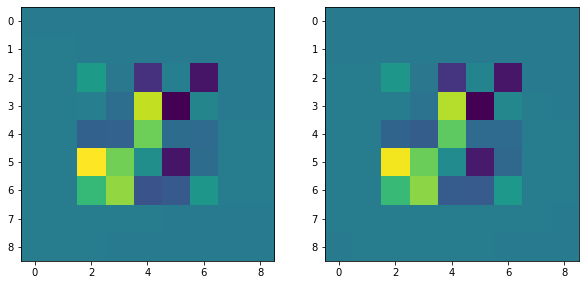

The reflected input.


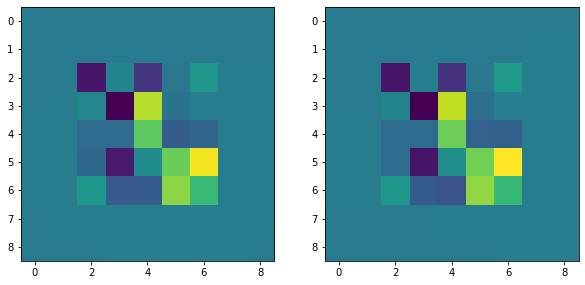


 SECOND LAYER:

The original input.


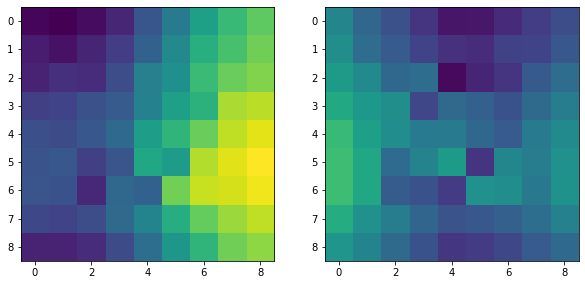

The reflected input.


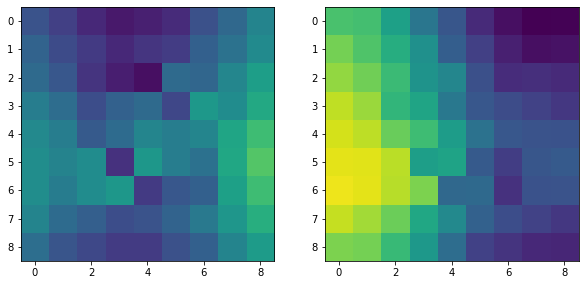

In [21]:
print('FIRST LAYER:\n')
vmax = torch.max(out_1[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_1_f[0,0,:,:,:]).item() < vmax else torch.max(out_1_f[0,0,:,:,:]).item()
vmin = torch.min(out_1[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_1_f[0,0,:,:,:]).item() < vmin else torch.min(out_1_f[0,0,:,:,:]).item()

print( 'The original input.')
plt.subplots(1,group.num_elements, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
#plt.tight_layout()
plt.show()

print( 'The reflected input.')
plt.subplots(1,group.num_elements, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_1_f.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
#plt.tight_layout()
plt.show()

print('\n SECOND LAYER:\n')
vmax = torch.max(out_2[0,0,:,:,:]).item()
vmax = vmax if torch.max(out_2_f[0,0,:,:,:]).item() < vmax else torch.max(out_2_f[0,0,:,:,:]).item()
vmin = torch.min(out_2[0,0,:,:,:]).item()
vmin = vmin if torch.min(out_2_f[0,0,:,:,:]).item() < vmin else torch.min(out_2_f[0,0,:,:,:]).item()

print( 'The original input.')

plt.subplots(1,group.num_elements, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
#plt.tight_layout()
plt.show()

print( 'The reflected input.')
plt.subplots(1,group.num_elements, figsize=(10,5))
for i in range(group.num_elements):
    plt.subplot(1,group.num_elements,i+1)
    plt.imshow(out_2_f.detach().numpy()[0,0,i,:,:], vmin=vmin, vmax=vmax)
#plt.tight_layout()
plt.show()